## Image segmentation with CamVid

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [33]:
!ls "/content/drive/My Drive/CamVid/"

models	test  testannot  train	trainannot  val  valannot


In [0]:
path = Path('/content/drive/My Drive/CamVid/')

In [35]:
path.ls()

[PosixPath('/content/drive/My Drive/CamVid/trainannot'),
 PosixPath('/content/drive/My Drive/CamVid/train'),
 PosixPath('/content/drive/My Drive/CamVid/val'),
 PosixPath('/content/drive/My Drive/CamVid/test'),
 PosixPath('/content/drive/My Drive/CamVid/testannot'),
 PosixPath('/content/drive/My Drive/CamVid/valannot'),
 PosixPath('/content/drive/My Drive/CamVid/models')]

## Data

In [36]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/content/drive/My Drive/CamVid/val/testB_19.bmp'),
 PosixPath('/content/drive/My Drive/CamVid/val/testB_15.bmp'),
 PosixPath('/content/drive/My Drive/CamVid/val/testB_9.bmp')]

In [37]:
lbl_names = get_image_files(path/ 'valannot')
lbl_names[:3]

[PosixPath('/content/drive/My Drive/CamVid/valannot/testB_1.bmp'),
 PosixPath('/content/drive/My Drive/CamVid/valannot/testB_2.bmp'),
 PosixPath('/content/drive/My Drive/CamVid/valannot/testB_3.bmp')]

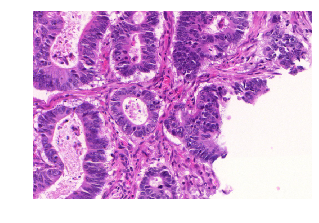

In [38]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['adenomatous','healthy','poorly differentiated','moderately differentiated','moderately-to-poorly differentiated'])

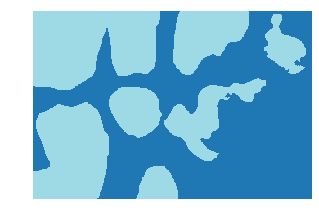

In [40]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [41]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([522, 775]), tensor([[[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]]]))

## Datasets

In [0]:
bs,size = 8,src_size//2

In [0]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

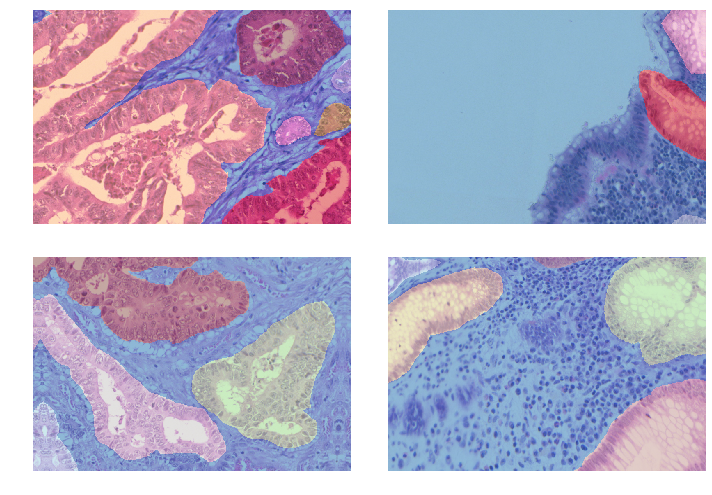

In [45]:
data.show_batch(2, figsize=(10,7))

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


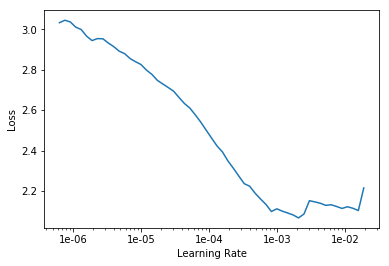

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=2e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,1.797555,1.140855,0.666712
2,1.108703,0.773872,0.779746
3,0.780712,0.517655,0.865303
4,0.618028,0.496499,0.866009
5,0.542120,0.484854,0.861792
6,0.490998,0.412183,0.857062
7,0.458476,0.363839,0.895877
8,0.426327,0.377631,0.885415
9,0.381760,0.307907,0.908467
10,0.325531,0.288052,0.907133


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100,lr)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.277594,0.273819,0.913931
2,0.271254,0.266760,0.916620
3,0.269084,0.269211,0.915474
4,0.273889,0.295377,0.914132
5,0.268701,0.312179,0.906329
6,0.295838,0.363080,0.902990
7,0.304576,0.323809,0.898795
8,0.290066,0.267403,0.920294
9,0.274901,0.274512,0.914693
10,0.275207,0.273877,0.920632


In [0]:
learn.save('stage-2');

## Go big

In [0]:
learn=None
gc.collect()

4194

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=8

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


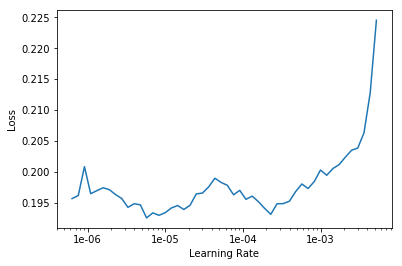

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.197342,0.242197,0.929653
2,0.195649,0.237269,0.930523
3,0.192771,0.253759,0.926123
4,0.197877,0.244278,0.931226
5,0.197267,0.255444,0.927470
6,0.206536,0.371523,0.913392
7,0.210372,0.267855,0.927450
8,0.210874,0.278875,0.915120
9,0.205951,0.256743,0.929986
10,0.184149,0.227250,0.939358


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/1000,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.163259,0.226014,0.939663
2,0.159221,0.223871,0.940497
3,0.159171,0.242006,0.938531
4,0.158257,0.223698,0.941702
5,0.156215,0.227719,0.941239
6,0.155152,0.226728,0.941032
7,0.150818,0.230083,0.940657
8,0.149479,0.229187,0.940948
9,0.148236,0.229072,0.941316
10,0.148074,0.234124,0.940629


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

## fin

In [0]:
# start: 480x360

In [0]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 64, 180, 240]    9408       False     
______________________________________________________________________
BatchNorm2d          [8, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [8, 64, 180, 240]    0          False     
______________________________________________________________________
MaxPool2d            [8, 64, 90, 120]     0          False     
______________________________________________________________________
Conv2d               [8, 64, 90, 120]     36864      False     
______________________________________________________________________
BatchNorm2d          [8, 64, 90, 120]     128        True      
______________________________________________________________________
ReLU                 [8, 64, 90, 120]     0          False     
______________________________________________________________